In [55]:
# import dependencies
import os
import yaml
import mysql.connector
import numpy as np 
import pandas as pd 
from scipy.stats import skew, kurtosis
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

## Data Ingestion
##### In this component  we will retreive/ fetch data from different data sources such as databases, data lakes data warehouses for simplicity we are fetching from mysql.

In [56]:
import mysql.connector
import pandas as pd
import os

class DataIngestion:
    def __init__(self):
        try:
            # Make the database connection
            self.conn = mysql.connector.connect(
                host='127.0.0.1',
                user='root',
                password='Bilal@123',
                database='rainfall'
            )
            # Make the cursor
            self.cursor = self.conn.cursor()
            print("Connection is Established")
        
        except Exception as e:
            print(f"Error during connection: {e}")
    
    def fetch_data(self):
        try:
            # Make the folder structure
            folder = 'data'
            os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
            filepath = os.path.join(folder, 'data.csv')
            
            # Select the table
            self.cursor.execute("SELECT * FROM rainfall")
            
            # Fetch all the data
            data = self.cursor.fetchall()
            
            # Fetch all the column names
            columns = [i[0] for i in self.cursor.description]
            
            # Convert the data into a DataFrame
            data = pd.DataFrame(data, columns=columns)
            
            # Dump the data into the file path in CSV format
            data.to_csv(filepath, index=False)
            print(f"Dataset has been saved at {filepath}")
        
        except Exception as e:
            print(f"Error during data fetching: {e}")

if __name__ == "__main__":
    obj = DataIngestion()
    obj.fetch_data()


Connection is Established
Dataset has been saved at data\data.csv


## Data Validation

##### In this component we will compare the features from real time prediction with the features we had while training if there is any mismatch we will trigger it and stop the further process

In [57]:
# Read the dataset
data = pd.read_csv("data/data.csv")

# Get all the features and convert them into a list
all_cols = [col for col in data.columns if col != 'rainfall']

# Get the schema columns
with open('schema.yaml', 'r') as yaml_file:
    schema = yaml.load(yaml_file, Loader=yaml.SafeLoader)

# Get the schema columns from the dictionary and convert to a list
all_schema = list(schema['COLUMNS'].keys())

# Initialize validation status
validation_status = True  # Assume valid unless a mismatch is found

# Iterate over all_cols to validate
for col in all_cols:
    if col not in all_schema:
        print(f"{col} was not in schema")
        validation_status = False
        break  # Exit loop if any column fails validation

# Make a folder structure for validation
folder = 'data_validation'
os.makedirs(folder, exist_ok=True)

# Set the validation file path
filepath = os.path.join(folder, "validation.txt")

# Write the validation status to the file
with open(filepath, 'w') as f:
    f.write(str(validation_status))  # Convert Boolean to string

print(f"Validation status has been saved at {filepath}")


Validation status has been saved at data_validation\validation.txt


In [58]:
data.head(3)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40,14.2


In [59]:
class DataValidation:
    
    def __init__(self):
        
        # read the dataset
        self.data= pd.read_csv("data/data.csv")
        # get all the columns and convert into list
        self.all_cols= [col for col in list(self.data.columns) if col != 'rainfall']
        # get the schema from yaml file
        with open('schema.yaml', 'r') as yaml_file:
            schema= yaml.load(yaml_file, yaml.SafeLoader)
        # get the columns from schema
        self.all_schema= list(schema["COLUMNS"].keys())
    
    def validation_file(self):
        
        # validation status
        validation_status= True
        
        # iterate over the all_cols
        for col in self.all_cols:
            if col not in self.all_schema:
                validation_status= False
                break
         
        # Make a folder structure for validation
        folder = 'data_validation'
        os.makedirs(folder, exist_ok=True)

        # Set the validation file path
        filepath = os.path.join(folder, "validation.txt")

        # Write the validation status to the file
        with open(filepath, 'w') as f:
            f.write(str(validation_status))  # Convert Boolean to string

        print(f"Validation status has been saved at {filepath}")

## Data Transformation

##### Here we will transform our data into a more suitable format required for ml model training such as encoding scaling missing value imputation, remove outlier duplicate values etc.

In [60]:
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40,13.7


In [61]:
# check number of unique values in days
data['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [62]:
# check the frequency count of rainfall
data['rainfall'].value_counts()

rainfall
yes    248
no     117
Name: count, dtype: int64

In [63]:
no= (117/ (248 + 117)) * 100
yes= (248/ (248 + 117)) * 100
print(f"Percentage of no category is {no} and yes {yes} in dataset")

Percentage of no category is 32.054794520547944 and yes 67.94520547945206 in dataset


In [64]:
data.isnull().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

In [65]:
data.duplicated().sum()

np.int64(0)

In [66]:
# drop day column 
data= data.drop(columns="day", axis=1)

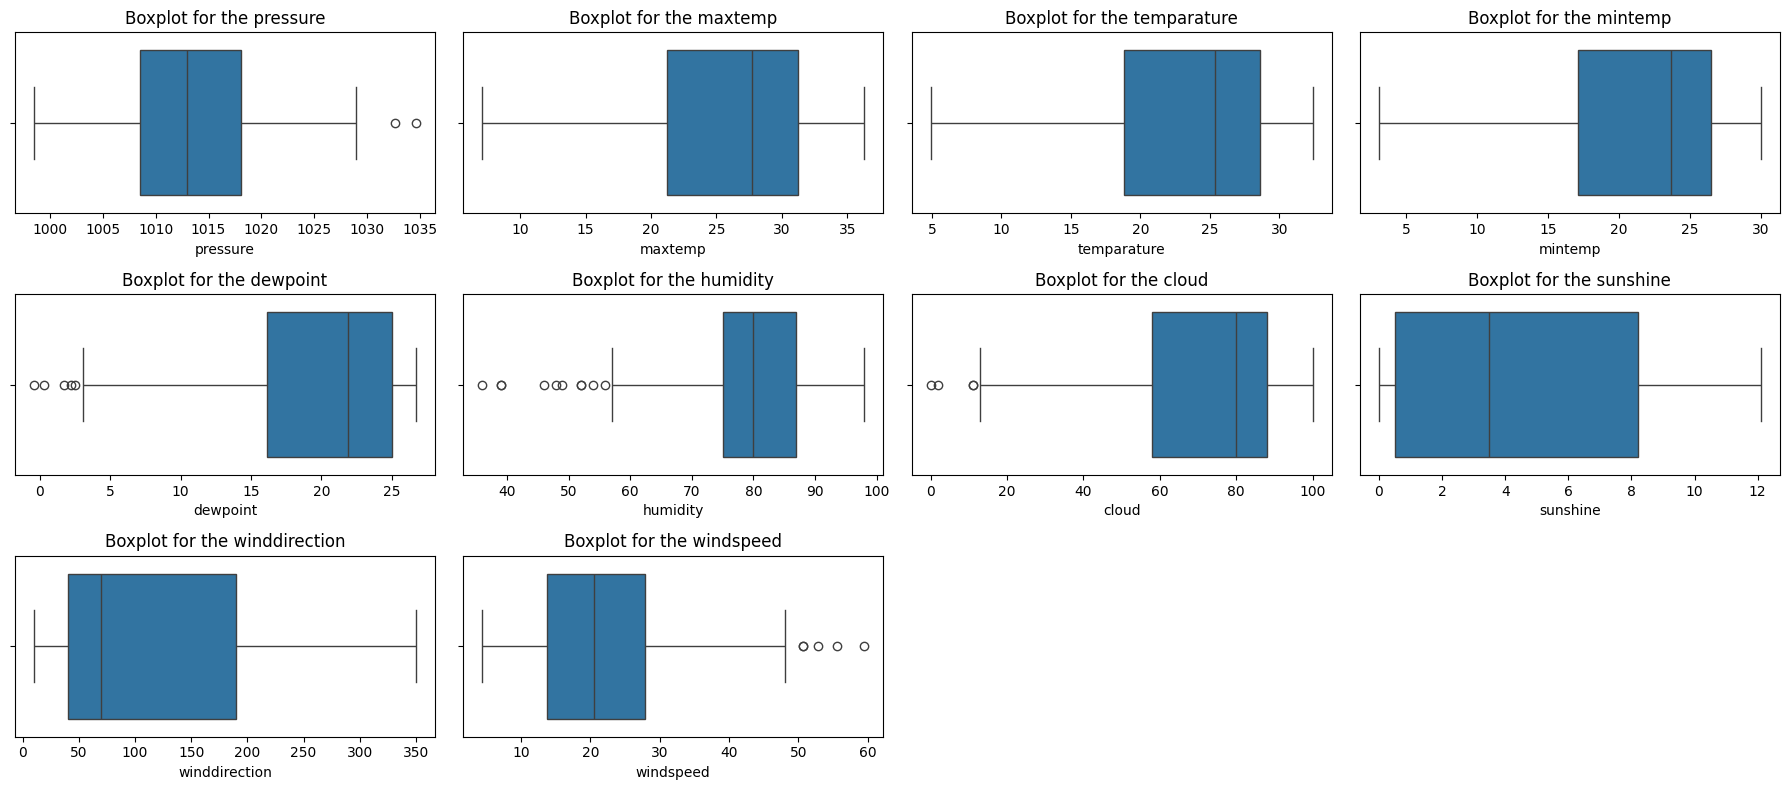

In [67]:
# Select numerical columns
num_cols = [col for col in data.columns if data[col].dtype != "object"]
no_of_cols = len(num_cols)

# Calculate the number of rows and columns for subplots
n_cols = int(np.ceil(np.sqrt(no_of_cols)))
n_rows = int(np.ceil(no_of_cols / n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

# Create boxplots for each numerical column
for index, column in enumerate(num_cols):
    sns.boxplot(data=data, x=column, ax=ax[index])
    ax[index].set_title(f"Boxplot for the {column}")

# Remove any unused axes
for j in range(len(num_cols), len(ax)):
    fig.delaxes(ax[j])  # Delete unused subplot axes

plt.tight_layout()
plt.show()

- pressure, humidity, cloud and windspeed has outliers while all num cols seems to be skewed.

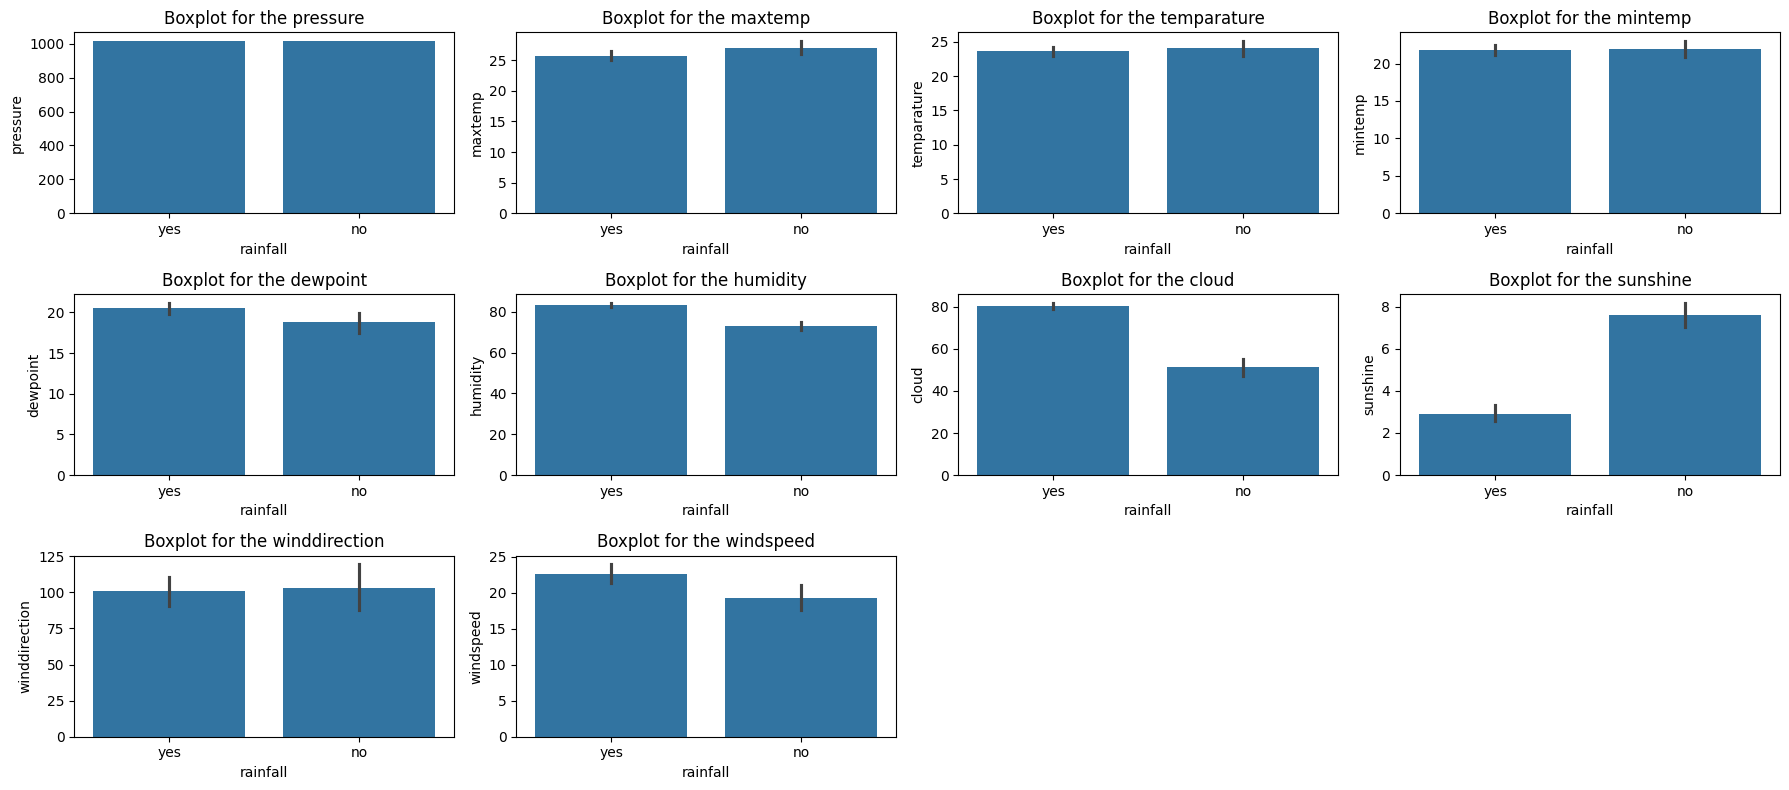

In [68]:
# Select numerical columns
num_cols = [col for col in data.columns if data[col].dtype != "object"]
no_of_cols = len(num_cols)

# Calculate the number of rows and columns for subplots
n_cols = int(np.ceil(np.sqrt(no_of_cols)))
n_rows = int(np.ceil(no_of_cols / n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

# Create boxplots for each numerical column
for index, column in enumerate(num_cols):
    sns.barplot(data=data, x='rainfall', y=column, ax=ax[index])
    ax[index].set_title(f"Boxplot for the {column}")

# Remove any unused axes
for j in range(len(num_cols), len(ax)):
    fig.delaxes(ax[j])  # Delete unused subplot axes

plt.tight_layout()
plt.show()

- on average when rainfall happens windspeed, cloud, humidity and dewpoints is more.

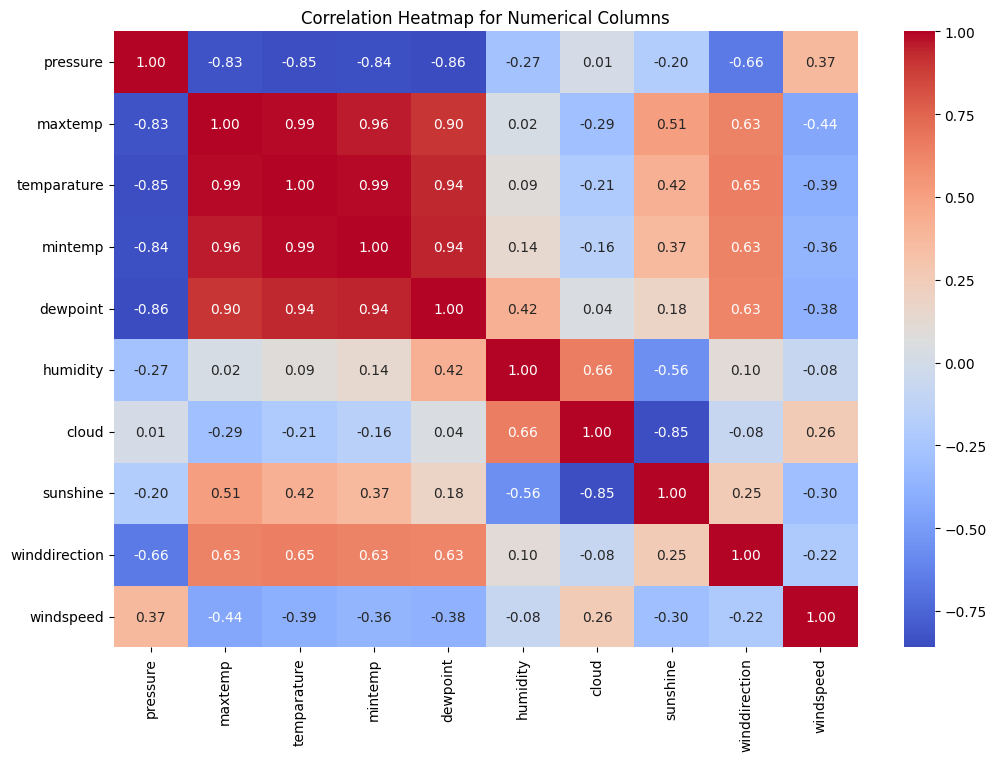

In [69]:
# Compute correlation matrix for numerical columns
correlation_matrix = data[num_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add a title
plt.title("Correlation Heatmap for Numerical Columns")

# Show the plot
plt.show()

- there are few columns that are seems highly correlated with each other but we cant drop of just basis of correlation until we know they make a linear relationship with each other.

In [70]:
data.shape

(365, 11)

In [71]:
def outlier_removal(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    # Iterate over the columns
    for col in columns:
        # Calculate Q1 and Q3
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        
        # Calculate IQR
        iqr = q3 - q1
        
        # Calculate upper and lower boundaries
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        
        # Trim the dataset
        data = data.loc[(data[col] >= lower_limit) & (data[col] <= upper_limit)]
    
    return data


In [72]:
clean_data= outlier_removal(data=data, columns=num_cols)

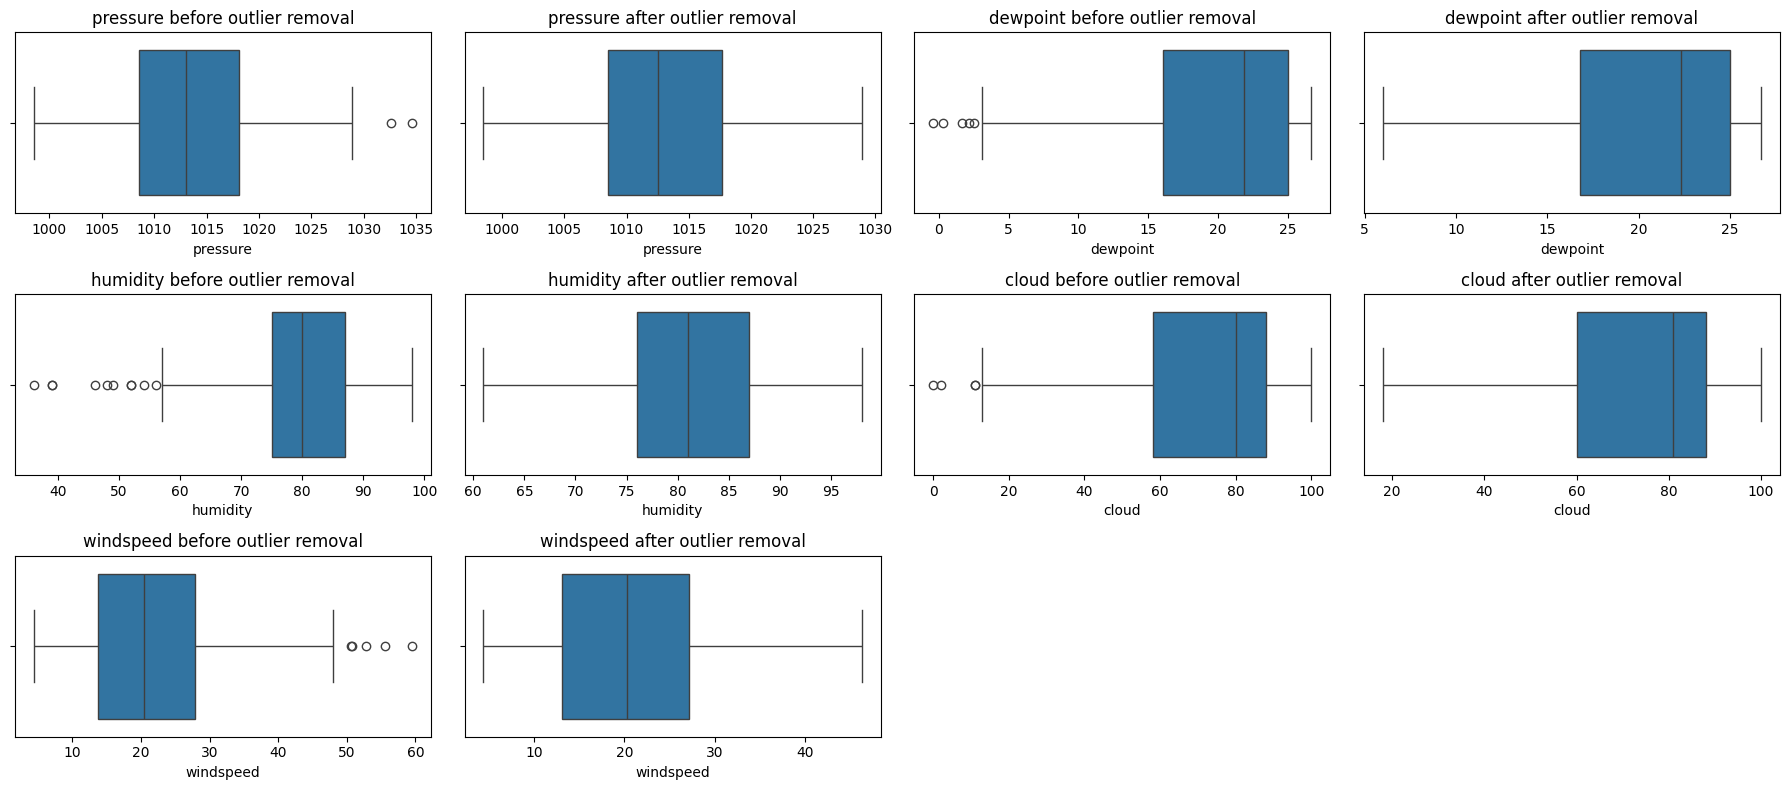

In [73]:
cols_with_outliers= ['pressure', 'dewpoint', 'humidity', 'cloud', 'windspeed']

total_cols = len(cols_with_outliers) * 2  # Each column has 2 plots
n_cols = int(np.ceil(np.sqrt(total_cols)))
n_rows = int(np.ceil(total_cols / n_cols))

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

for index, column in enumerate(cols_with_outliers):
    # Plot the column before outlier removal
    sns.boxplot(data=data, x=column, ax=ax[index * 2])
    ax[index * 2].set_title(f"{column} before outlier removal")

    # Plot the column after outlier removal
    sns.boxplot(data=clean_data, x=column, ax=ax[index * 2 + 1])
    ax[index * 2 + 1].set_title(f"{column} after outlier removal")

# Hide any unused axes
for extra_ax in ax[len(cols_with_outliers) * 2:]:
    extra_ax.axis("off")

plt.tight_layout()
plt.show()


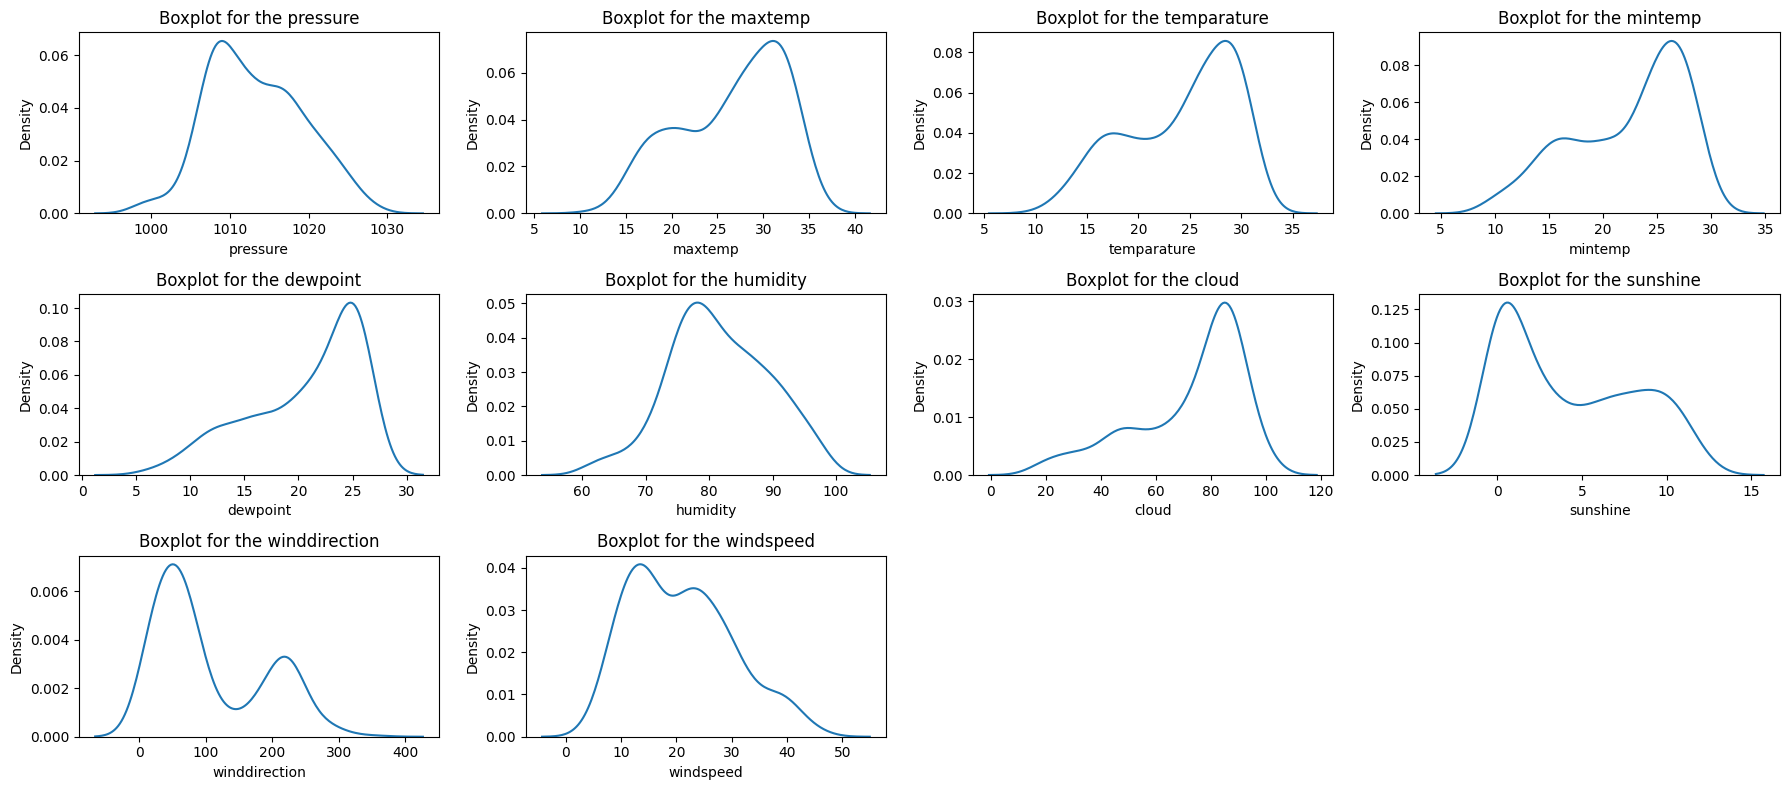

In [74]:
# Select numerical columns
num_cols = [col for col in clean_data.columns if clean_data[col].dtype != "object"]
no_of_cols = len(num_cols)

# Calculate the number of rows and columns for subplots
n_cols = int(np.ceil(np.sqrt(no_of_cols)))
n_rows = int(np.ceil(no_of_cols / n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

# Create boxplots for each numerical column
for index, column in enumerate(num_cols):
    sns.kdeplot(data=clean_data, x=column, ax=ax[index])
    ax[index].set_title(f"Boxplot for the {column}")

# Remove any unused axes
for j in range(len(num_cols), len(ax)):
    fig.delaxes(ax[j])  # Delete unused subplot axes

plt.tight_layout()
plt.show()

- windspeed, dewpoint and pressure seems to be normally distributed.

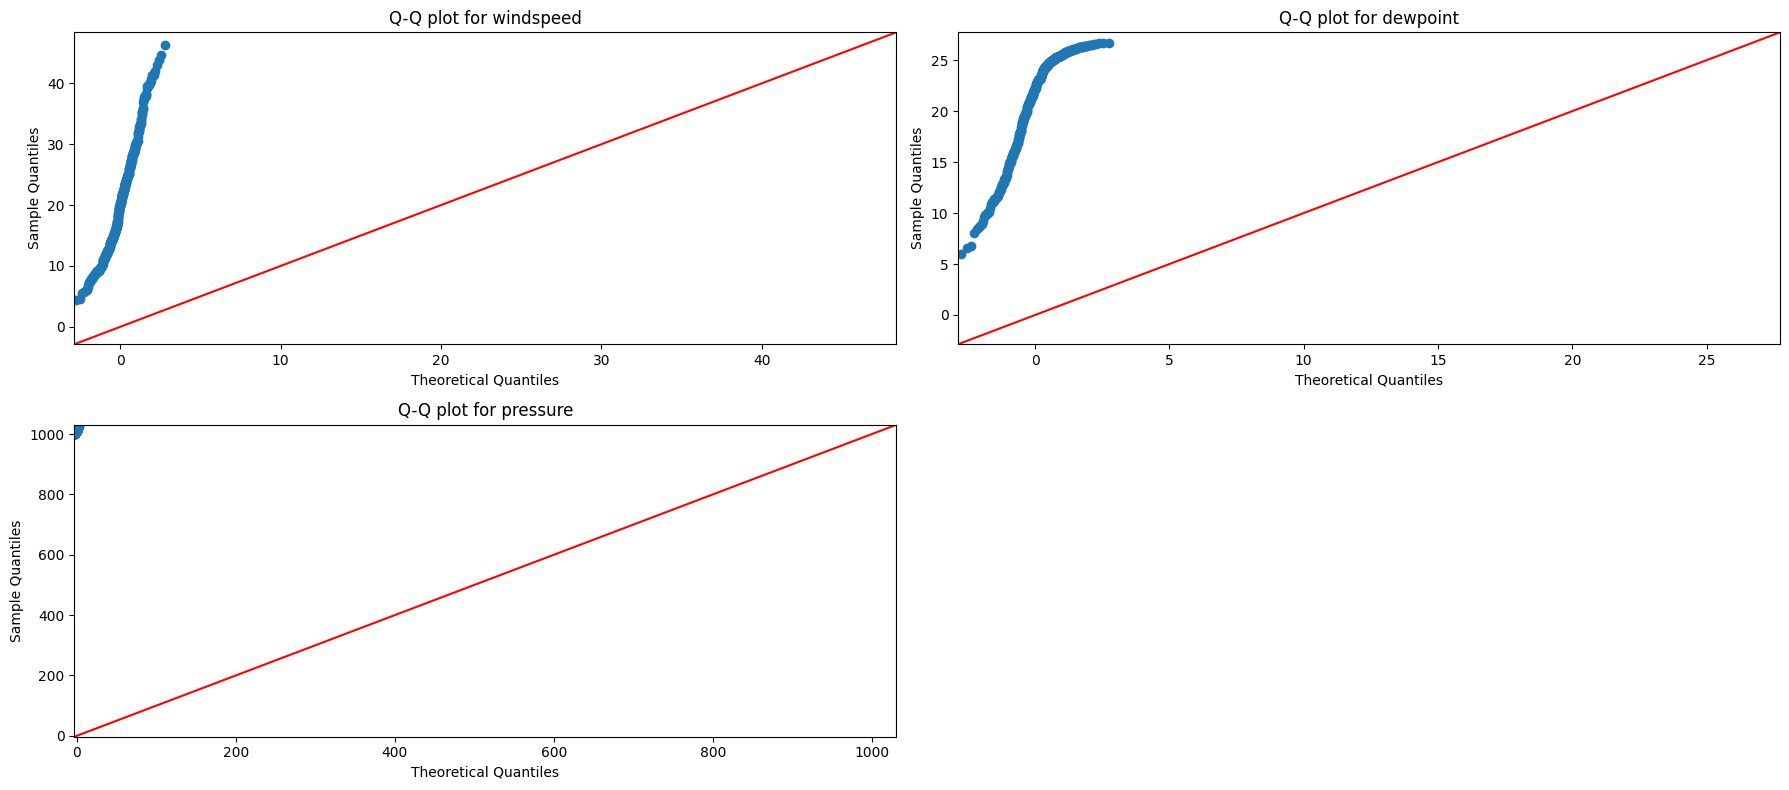

In [75]:
# Assuming clean_data is already defined, and the columns are specified
cols = ['windspeed', 'dewpoint', 'pressure']
no_of_cols = len(cols)

# Calculate the number of rows and columns for subplots
n_cols = int(np.ceil(np.sqrt(no_of_cols)))
n_rows = int(np.ceil(no_of_cols / n_cols))

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

# Create Q-Q plots for each column
for index, column in enumerate(cols):
    sm.qqplot(clean_data[column], line ='45', ax=ax[index]) 
    ax[index].set_title(f"Q-Q plot for {column}")

# Remove any unused axes
for j in range(len(cols), len(ax)):
    fig.delaxes(ax[j])  # Delete unused subplot axes

plt.tight_layout()
plt.show()

- Non of them are close to normal

In [76]:
def find_skewness_type(data: pd.DataFrame, columns: list) -> str:
    
    for column in columns:
        skewness= skew(data[column])
        taildness= kurtosis(data[column])
        
        print(f"{column} has skewness: {skewness} and kurtosis: {taildness}")

find_skewness_type(data=clean_data, columns= num_cols)

pressure has skewness: 0.2261579972237463 and kurtosis: -0.5040784794565991
maxtemp has skewness: -0.4926235019469285 and kurtosis: -0.8881314810321328
temparature has skewness: -0.5680981562920745 and kurtosis: -0.8840524736716717
mintemp has skewness: -0.6358486909577531 and kurtosis: -0.7654456444820368
dewpoint has skewness: -0.8183371816098098 and kurtosis: -0.43354426071103846
humidity has skewness: -0.01974807647758613 and kurtosis: -0.36905540929613734
cloud has skewness: -1.0149909439933122 and kurtosis: 0.04758805283723344
sunshine has skewness: 0.4125034758416417 and kurtosis: -1.2959353111783196
winddirection has skewness: 0.740244486505142 and kurtosis: -0.8639111256952434
windspeed has skewness: 0.48619056028793745 and kurtosis: -0.5098942850998771


- transformation depends upon your goals with the model such as if working with linear models they assume data is linear so we do it but we can also loss meaning of data and interpretability so before doing it understand the requirements then do it . for us now goal is to get better results so we will do the transformation.

In [77]:
transformation= PowerTransformer(method='yeo-johnson')
data= transformation.fit_transform(clean_data[num_cols])
transform_data= pd.DataFrame(data, columns=transformation.get_feature_names_out())

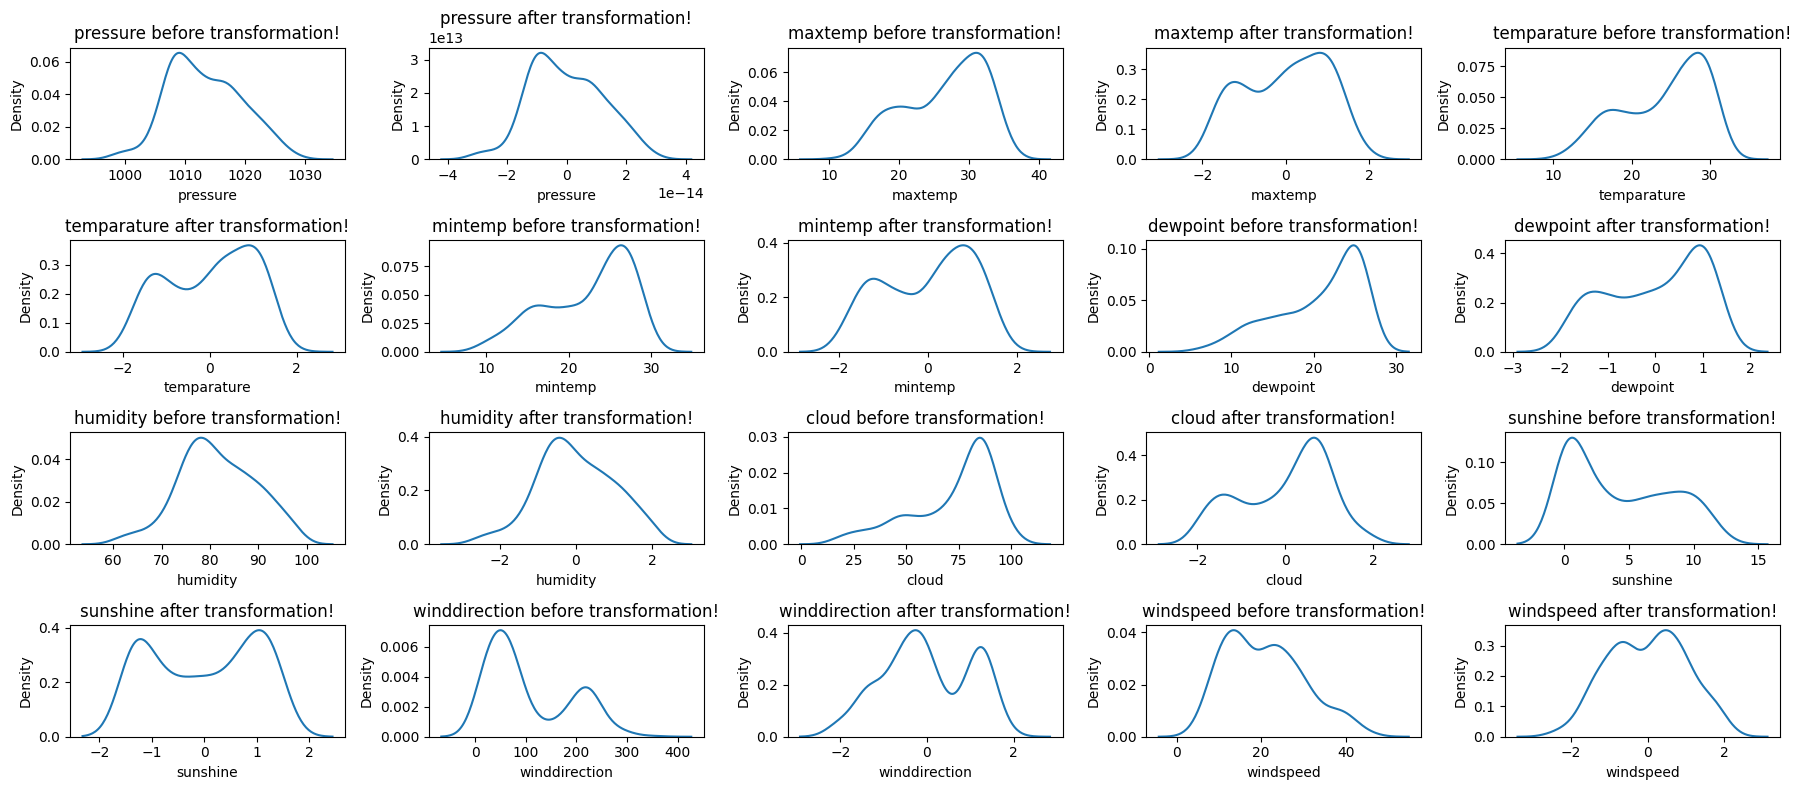

In [78]:
total_cols = len(num_cols) * 2  # Each column has 2 plots
n_cols = int(np.ceil(np.sqrt(total_cols)))
n_rows = int(np.ceil(total_cols / n_cols))

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 8))
ax = ax.flatten()

for index, column in enumerate(num_cols):
    # Plot the column before outlier removal
    sns.kdeplot(data=clean_data, x=column, ax=ax[index * 2])
    ax[index * 2].set_title(f"{column} before transformation!")

    # Plot the column after outlier removal
    sns.kdeplot(data=transform_data, x=column, ax=ax[index * 2 + 1])
    ax[index * 2 + 1].set_title(f"{column} after transformation!")

# Hide any unused axes
for extra_ax in ax[len(num_cols) * 2:]:
    extra_ax.axis("off")

plt.tight_layout()
plt.show()

- As we can see we stabilize the variance in a lower range but always do transformation according to the requirements.

In [79]:
clean_data.replace(to_replace={'yes':1, 'no':0}, inplace=True)

C:\Users\Bilal Ahmad\AppData\Local\Temp\ipykernel_15984\2810202436.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_data.replace(to_replace={'yes':1, 'no':0}, inplace=True)


In [80]:
clean_data["rainfall"].value_counts()

rainfall
1    241
0    102
Name: count, dtype: int64

In [81]:
transform_data

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2.481348e-14,-1.184281,-1.151159,-1.133758,-1.439060,-1.214817,-1.308071,1.170381,0.025903,0.676827
1,1.737499e-14,-0.926488,-1.063311,-1.074644,-1.116498,-0.072165,0.465926,-0.958031,-0.492165,-0.509402
2,1.287859e-14,-1.128961,-1.002810,-0.951154,-0.654829,1.713961,1.079560,-1.386671,-0.725409,-0.654990
3,1.132427e-14,-0.835489,-0.795371,-0.769746,-0.579695,1.074928,0.840039,-0.740771,-0.492165,-0.308899
4,5.384582e-15,-0.985745,-0.778724,-0.574670,-0.360752,1.713961,0.324916,-1.386671,-0.725409,-0.723494
...,...,...,...,...,...,...,...,...,...,...
338,1.870726e-14,-1.330635,-1.235550,-1.119143,-1.201341,0.309728,0.998451,-1.386671,-1.014189,-0.131510
339,2.614575e-14,-1.356337,-1.289907,-1.205210,-1.472435,-0.834457,0.611845,-0.740771,-1.398467,0.639965
340,2.481348e-14,-1.317680,-1.235550,-1.191135,-1.416193,-0.834457,0.122493,0.389724,-0.125017,1.278453
341,2.370326e-14,-1.278395,-1.289907,-1.352974,-1.416193,-0.453567,0.686661,-0.645137,-1.398467,0.144833


In [82]:
scaler= StandardScaler()
data= scaler.fit_transform(transform_data[num_cols])
final_data= pd.DataFrame(data=data, columns=scaler.get_feature_names_out())
final_data.head(4)

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2.044343,-1.184281,-1.151159,-1.133758,-1.439060,-1.214817,-1.308071,1.170381,0.025903,0.676827
1,1.431409,-0.926488,-1.063311,-1.074644,-1.116498,-0.072165,0.465926,-0.958031,-0.492165,-0.509402
2,1.060905,-1.128961,-1.002810,-0.951154,-0.654829,1.713961,1.079560,-1.386671,-0.725409,-0.654990
3,0.932829,-0.835489,-0.795371,-0.769746,-0.579695,1.074928,0.840039,-0.740771,-0.492165,-0.308899


In [83]:
# adding cat col back into the transformed dataset
final_data['rainfall']= clean_data['rainfall']

In [84]:
final_data

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,2.044343,-1.184281,-1.151159,-1.133758,-1.439060,-1.214817,-1.308071,1.170381,0.025903,0.676827,1.0
1,1.431409,-0.926488,-1.063311,-1.074644,-1.116498,-0.072165,0.465926,-0.958031,-0.492165,-0.509402,1.0
2,1.060905,-1.128961,-1.002810,-0.951154,-0.654829,1.713961,1.079560,-1.386671,-0.725409,-0.654990,1.0
3,0.932829,-0.835489,-0.795371,-0.769746,-0.579695,1.074928,0.840039,-0.740771,-0.492165,-0.308899,1.0
4,0.443397,-0.985745,-0.778724,-0.574670,-0.360752,1.713961,0.324916,-1.386671,-0.725409,-0.723494,1.0
...,...,...,...,...,...,...,...,...,...,...,...
338,1.541188,-1.330635,-1.235550,-1.119143,-1.201341,0.309728,0.998451,-1.386671,-1.014189,-0.131510,1.0
339,2.154122,-1.356337,-1.289907,-1.205210,-1.472435,-0.834457,0.611845,-0.740771,-1.398467,0.639965,1.0
340,2.044343,-1.317680,-1.235550,-1.191135,-1.416193,-0.834457,0.122493,0.389724,-0.125017,1.278453,0.0
341,1.952860,-1.278395,-1.289907,-1.352974,-1.416193,-0.453567,0.686661,-0.645137,-1.398467,0.144833,1.0


In [85]:
class OutilerRemoval:
    
    def __init__(self):
        self.lower_limit= None
        self.upper_limit= None
        
    def fit(self, data: pd.DataFrame, columns: list):
        for column in columns:
            percentile25= data[column].quantile(0.25)
            percentile75= data[column].quantile(0.75)
            iqr= percentile75 - percentile25
            
            # calculate the lower and upper limit
            self.lower_limit= percentile25 - 1.5 * iqr
            self.upper_limit= percentile75 + 1.5 * iqr
    
    def transform(self, data: pd.DataFrame, columns: list) -> pd.DataFrame:
        
        for column in columns:
            data= data[
                (data[column] >= self.lower_limit) & (data[column] <= self.upper_limit)
            ]
        return data
    
    def fit_transform(self, data: pd.DataFrame, columns: list): 
        self.fit(data=data, columns=columns)
        return self.transform(data=data, columns=columns)
        

In [102]:
class MissingValueImputer:
    def __init__(self, source: str):
        # read the data from the source
        self.source = source
        self.data = pd.read_csv(self.source)
    
    def fit(self):
        self.missing_data_cols = []
        self.missing_data = self.data.isnull().sum()
        # iterate over the missing_data to see if there is any missing data
        for column, value in self.missing_data.items():
            if value != 0:
                self.missing_data_cols.append(column)
    
    def transform(self):
        for column in self.missing_data_cols:
            if self.data[column].dtype == 'object':
                mode = self.data[column].mode().iloc[0]
                self.data[column].fillna(mode, inplace=True)
            else:
                mean = self.data[column].mean()
                self.data[column].fillna(mean, inplace=True)
    
    def fit_transform(self):
        # applying the learned parameter
        self.fit()
        self.transform()
        return self.data


In [96]:
obj= MissingValueImputer(source='data/data.csv')
obj.missing_value_checker()

No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!
No Missing Value Found!


In [87]:
data= pd.read_csv('data/data.csv')
missing_data= data.isnull().sum()
for column, value in missing_data.items():
    if value !=0:
        if data[column].dtype != 'object':
            mode= data[column].mode()
            data[column].fillna(mode)
        else:
            mean= data[column].mean()
            data[column].fillna(mean)
        

In [89]:
class DataTransformation:
    
    def __init__(self, source: str):
        self.source= source
        # we will read the data form the source
        self.data= pd.read_csv(source)
        

In [98]:
# added till now